In [92]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline


from sklearn.naive_bayes import BernoulliNB
from sklearn import tree
from sklearn.linear_model import LogisticRegression
from sklearn.cross_validation import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.cross_validation import train_test_split
import math


In [93]:
df=pd.read_csv("training_data_2_csv_UTF.csv",encoding='iso-8859-1')
X_train_raw=df[df.columns.tolist()[:-1]]
y_train=df[df.columns.tolist()[-1:]]
X_test_raw=pd.read_csv("test_data_4_students.csv",encoding='iso-8859-1')


X_test_raw.head()


,id,id_str,screen_name,location,description,url,followers_count,friends_count,listed_count,created_at,favorites_count,verified,statuses_count,lang,status,default_profile,default_profile_image,has_extended_profile,name,bot
0,2.281293e+09,2281292622,__keating,brooklyn,lgbt editor at @buzzfeed. shannon.keating@buzz...,https://t.co/QneJmYRyhj,4466,1295,111,Tue Jan 07 23:26:52 +0000 2014,1579,TRUE,3036.0,en,{'created_at': 'Tue Apr 11 15:31:51 +0000 2017...,FALSE,FALSE,FALSE,shannon keating,NaN
1,2.344040e+09,2344040251,_callme_Dani,"Los Angeles, CA",News Curation Editor @BuzzFeedNews \rI do a lo...,NaN,295,1016,10,Fri Feb 14 19:45:56 +0000 2014,300,FALSE,618.0,en,{'created_at': 'Tue Apr 11 00:56:02 +0000 2017...,FALSE,FALSE,FALSE,Danielle Hopkins,NaN
2,7.658713e+08,765871267,_little_britt_,NaN,Family comes first! Also I am in love with piz...,https://t.co/E7DE1cJB7e,1001678,3017,14,8/18/2012 15:13,13040,TRUE,3329.0,en,"{'place': None, 'retweeted': False, 'favorited...",TRUE,FALSE,TRUE,Brittney Smith,NaN
3,4.772373e+09,4772373433,134k5,NaN,@BuzzFeedJapan â°Â Â @cnet_japan / DMÅ½ÃÃâ...,https://t.co/Cbguzs2PjT,445,487,17,Sun Jan 17 07:11:45 +0000 2016,1112,FALSE,46.0,ja,{'created_at': 'Sat Apr 08 08:41:08 +0000 2017...,FALSE,FALSE,TRUE,Keigo Isashi,NaN
4,1.324549e+09,None,2181chrom_bot,Ã¨â¡ÂªÃ¥Ëâ Ã£ÂÂ®Ã¥Â¤Â©Ã¥Â¹â¢,Ã£ÂâÃ£âÅÃ£ÂÂ¯FEÃ¨Â¦Å¡Ã©â âÃ£ÂÂ®Ã£â...,http://t.co/10Swf6luED,187,68,13,Wed Apr 03 13:00:42 +0000 2013,None,None,690359.0,ja,"{u'lang': u'ja', u'text': u'@2181lucina_bot \u...",None,None,None,Ã£ÆâÃ£âÂ¤Ã¥Â»ÆÃ£âÂ¯Ã£ÆÂ­Ã£ÆÂ bot,NaN


In [94]:
##First check if there's any NaN value in numerical features. There are no
print X_train_raw.isnull().sum()
print X_test_raw.isnull().sum()


id                          0
id_str                      0
screen_name                 0
location                 1020
description               403
url                      1296
followers_count             0
friends_count               0
listedcount                 0
created_at                  0
favourites_count            0
verified                    0
statuses_count              0
lang                        0
status                     34
default_profile             0
default_profile_image       0
has_extended_profile       99
name                        0
dtype: int64
id                        41
id_str                    41
screen_name               41
location                 165
description               57
url                      153
followers_count           41
friends_count             41
listed_count              41
created_at                41
favorites_count           41
verified                  41
statuses_count            41
lang                      41
status     

In [95]:
###Need to drop the 576th row to the last from test data because they're blank
X_test_raw=X_test_raw.drop(X_test_raw.index[575:])

## Below code only serve as making a copy of training and test sets, in the same time converting all NaN in text features to 1
##so that we won't modify the original data when we make change to the data we experiment with 
X_train=X_train_raw.fillna(value=1)
y_train=y_train.fillna(value=1)
X_test=X_test_raw.fillna(value=1)[X_test_raw.columns.tolist()[:-1]]



###Need to change test sets header to align with train set
X_test.columns=X_train.columns

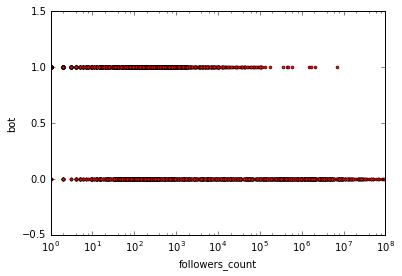

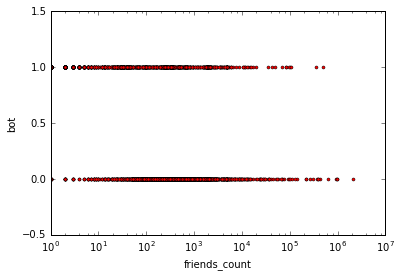

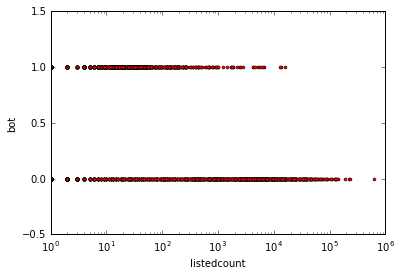

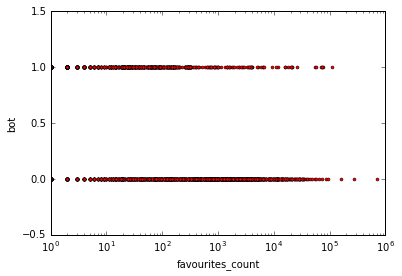

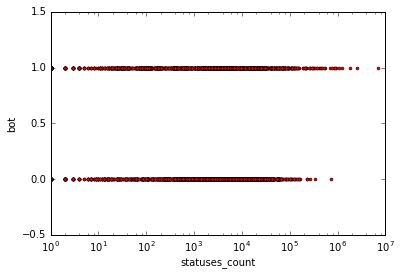

In [96]:
##Get a distribution graph for the numerical data in training set, showing the bot and nonbot density in d
l=['followers_count', 'friends_count', 'listedcount', 'favourites_count', 'statuses_count']
X_1=X_train[l]
col=X_1.columns

for i in col:
    plt.plot(X_1[i],y_train['bot'],'ro',ms='3.0')
    plt.xlabel(i)
    plt.xscale('log')
    plt.ylabel("bot")
    plt.ylim(-0.5, 1.5)
    plt.show()


In [97]:
## All values in numerical features in train set are valid, but there are "None" value in test set.
## Need to Check how many "None" in the test set.
## As below we see there're too many "None "favourites_count, we'll drop this feature because 
## it's useless with so many "None" that even filling in mean doesn't have any meaning

l=['followers_count', 'friends_count', 'listedcount', 'favourites_count', 'statuses_count','verified', 'default_profile','default_profile_image','has_extended_profile'
]
for i in range(len(l)):
    count=0
    for j in X_test[l[i]]:
        if j=='None':
            count+=1
    print str(count)+' None values in '+str(l[i])+' in test data,', str(100*round(count/float(len(X_test)),4))+'%'



1 None values in followers_count in test data, 0.17%
12 None values in friends_count in test data, 2.09%
21 None values in listedcount in test data, 3.65%
196 None values in favourites_count in test data, 34.09%
0 None values in statuses_count in test data, 0.0%
96 None values in verified in test data, 16.7%
130 None values in default_profile in test data, 22.61%
187 None values in default_profile_image in test data, 32.52%
196 None values in has_extended_profile in test data, 34.09%


In [98]:
## Try for the best range of numerical features, so that we can compress the attribute values number from thousands to a few
## On;y followers_count, friends_count and listedcount have a reasonably good "cut" in different range
## We can reduce the values numbers and select the above 3 features

l=['followers_count', 'friends_count', 'listedcount', 'favourites_count', 'statuses_count']
print l[0]+' Distribution'
print 'Under 10:',
tmp=y_train['bot'][X_train_raw[l[0]]<=10]
print np.sum(tmp),'bots and',len(tmp)-np.sum(tmp), 'nonbots'
print 'Over 50000:',
tmp=y_train['bot'][X_train_raw[l[0]]>50000]
print np.sum(tmp),'bots and',len(tmp)-np.sum(tmp), 'nonbots'
print

print l[1]+' Distribution'
print 'Under 7:',
tmp=y_train['bot'][X_train_raw[l[1]]<=7]
print np.sum(tmp),'bots and',len(tmp)-np.sum(tmp), 'nonbots'
print 'Over 10000:',
tmp=y_train['bot'][X_train_raw[l[1]]>10000]
print np.sum(tmp),'bots and',len(tmp)-np.sum(tmp), 'nonbots'

print 
print l[2]+' Distribution'
print 'Under 250:',
tmp=y_train['bot'][X_train_raw[l[2]]<=250]
print np.sum(tmp),'bots and',len(tmp)-np.sum(tmp), 'nonbots'
print 'Over 500:',
tmp=y_train['bot'][X_train_raw[l[2]]>500]
print np.sum(tmp),'bots and',len(tmp)-np.sum(tmp), 'nonbots'


print 
print l[3]+' Distribution'
print 'Under 3:',
tmp=y_train['bot'][X_train_raw[l[3]]<=3]
print np.sum(tmp),'bots and',len(tmp)-np.sum(tmp), 'nonbots'
print 'Over 10000:',
tmp=y_train['bot'][X_train_raw[l[3]]>330]
print np.sum(tmp),'bots and',len(tmp)-np.sum(tmp), 'nonbots'


print 
print l[4]+' Distribution'
print 'Under 2:',
tmp=y_train['bot'][X_train_raw[l[4]]<=2]
print np.sum(tmp),'bots and',len(tmp)-np.sum(tmp), 'nonbots'
print 'Over 2:',
tmp=y_train['bot'][X_train_raw[l[4]]>2]
print np.sum(tmp),'bots and',len(tmp)-np.sum(tmp), 'nonbots'

followers_count Distribution
Under 10: 331 bots and 63 nonbots
Over 50000: 29 bots and 543 nonbots

friends_count Distribution
Under 7: 617 bots and 47 nonbots
Over 10000: 22 bots and 62 nonbots

listedcount Distribution
Under 250: 1256 bots and 802 nonbots
Over 500: 39 bots and 594 nonbots

favourites_count Distribution
Under 3: 792 bots and 236 nonbots
Over 10000: 82 bots and 704 nonbots

statuses_count Distribution
Under 2: 126 bots and 48 nonbots
Over 2: 1195 bots and 1428 nonbots


In [99]:
X_train.head()

,id,id_str,screen_name,location,description,url,followers_count,friends_count,listedcount,created_at,favourites_count,verified,statuses_count,lang,status,default_profile,default_profile_image,has_extended_profile,name
0,8.160000e+17,"""815745789754417152""","""HoustonPokeMap""","""Houston, TX""","""Rare and strong PokÅ½mon in Houston, TX. See ...","""https://t.co/dnWuDbFRkt""",1291,0,10,"""Mon Jan 02 02:25:26 +0000 2017""",0,False,78554,"""en""","{\r ""created_at"": ""Sun Mar 12 15:44:04 +0...",True,False,False,"""Houston PokÅ½ Alert"""
1,4.843621e+09,4843621225,kernyeahx,"Templeville town, MD, USA",From late 2014 Socium Marketplace will make sh...,1,1,349,0,2/1/2016 7:37,38,False,31,en,null,True,False,False,Keri Nelson
2,4.303727e+09,4303727112,mattlieberisbot,1,"Inspired by the smart, funny folks at @replyal...",https://t.co/P1e1o0m4KC,1086,0,14,Fri Nov 20 18:53:22 +0000 2015,0,False,713,en,"{'retweeted': False, 'is_quote_status': False,...",True,False,False,Matt Lieber Is Bot
3,3.063139e+09,3063139353,sc_papers,1,1,1,33,0,8,2/25/2015 20:11,0,False,676,en,Construction of human anti-tetanus single-chai...,True,True,False,single cell papers
4,2.955142e+09,2955142070,lucarivera16,"Dublin, United States",Inspiring cooks everywhere since 1956.,1,11,745,0,1/1/2015 17:44,146,False,185,en,null,False,False,False,lucarivera16


In [100]:

## Preprossing: Since id and id_str are irrelavant, setting them all to 1, will drop them latter anyways
for i in X_train.index:
    X_train.set_value(i,'id',1)
    X_train.set_value(i,'id_str',1)
for i in X_test.index:
    X_test.set_value(i,'id',1)
    X_test.set_value(i,'id_str',1)

## For text features 'screen_name','description','status','name', we can create a new numerical feature 'botword' where only when
## the four test features contains 'bot', that the new feature is set to 1, otherwise set to 0.
## So that we simplied the four features into one 0/1 feature

def extract_bot(df):
    
        robot_list=['screen_name','description','status','name']
        botlist=[0]*len(df)
        for col in robot_list:
            alist=[]
            for i in df[col]:
                try:
                    alist.append(i.lower())
                except:
                    alist.append(i)
            for i in range(len(alist)):
                try:
                    if 'bot' in alist[i]:
                        botlist[i]=1
                except: True
        selist=pd.Series(botlist,index=df.index)
        df['botword']=selist
        return df
    
## For the created_at feature we tried extracted the created year but the test set iw hugely different than the train set. We wil drop it

def extract_year(df):
    import string
    counts_list= ['created_at']
    for col in counts_list:
        alist=[]
        for i in df[col]:
            alist.append(i)
        for i in range(len(alist)):
            words=str(alist[i])
            for c in string.punctuation:
                words=words.replace(c, ' ')
            words=words.split()
            for w in words:
                if ('20' in w) and len(w)==4:
#                    if int(w)>=2014:
#                        alist[i]=1
#                    if int(w)<=2010:
#                        alist[i]=0
#                    else: alist[i]=2
                    alist[i]=int(w)-2000
        selist=pd.Series(alist,index=df.index)
        df[col]=selist
        median=np.median(df[col])
        print median
        df[col]=df[col]-median
    return df

## Since we've  a new feature simplying the text features, we actually don't need this anymore

def convert_string(df):
    ##DocPreprossing: Convert all value to numeric(like '123' to 123), for string values of characters, convert them to NaN
    df=df.apply(pd.to_numeric,errors='coerce')
        
    ##DocPreprossing: Convert all NaN value to 1
    ##So to this point, for all featues with string values of characters, if it's blank, it is converted to 0, else it's 1
    ##So that we classify blank and strings into 0 and 1 value for those features but still keep numeric as numeric
    return df

## Used as backup function, we don't use it for now because there're too many non-valid values in test set. We drop the true false features
def convert_truefalse(df):
    counts_list= ['verified','default_profile','default_profile_image','has_extended_profile']
    for col in counts_list:
        alist=[]
        for i in df[col]:
            alist.append(i)
        for i in range(len(alist)):
            if alist[i]=='TRUE' or alist[i]==True:
                alist[i]=1
            elif alist[i]=='FALSE' or alist[i]==False:
                alist[i]=0
            else: alist[i]=2
        selist=pd.Series(alist,index=df.index)
        df[col]=selist
    return df


## Preprossing: We reduce the range of numerical to 0-2.
def preProcess(df,clfType):
    columns=df.columns.tolist()
    df=df[columns[2:]]

    if str(clfType)==str(type(BernoulliNB())) or str(clfType)==str(type(tree.DecisionTreeClassifier())):
        #print 'Using '+str(clfType)
#        counts_list= [columns[6],columns[7],columns[8],columns[10],columns[12]]  ##Only change features with multi-values

        counts_list= ['followers_count']
        for col in counts_list:
            alist=[]
            for i in df[col]:
                alist.append(i)
            for i in range(len(alist)):
                if alist[i]<=10:
                    alist[i]=0
                elif (alist[i]>10 and alist[i]<=50000):
                    alist[i]=2
                else: 
                    alist[i]=1
            selist=pd.Series(alist,index=df.index)
            df[col]=selist

        counts_list= ['friends_count']
        for col in counts_list:
            alist=[]
            for i in df[col]:
                alist.append(i)
            for i in range(len(alist)):
                if alist[i]>10000:
                    alist[i]=1
                elif alist[i]<=7:
                    alist[i]=0
                else: alist[i]=2
            selist=pd.Series(alist,index=df.index)
            df[col]=selist
            

        
        counts_list= [df.columns.tolist()[6]]   ##listedcount
        for col in counts_list:
            alist=[]
            for i in df[col]:
                alist.append(i)
            for i in range(len(alist)):
                if alist[i]>800:
                    alist[i]=1
                elif alist[i]<250:
                    alist[i]=2
                else: alist[i]=2
            selist=pd.Series(alist,index=df.index)
            df[col]=selist


        counts_list=[df.columns.tolist()[8]] ##favouritecount
        for col in counts_list:
            alist=[]
            for i in df[col]:
                alist.append(i)
            for i in range(len(alist)):
                if alist[i]<3:
                    alist[i]=0
                elif alist[i]>330:
                    alist[i]=1
                else: alist[i]=2
            selist=pd.Series(alist,index=df.index)
            df[col]=selist

        counts_list=['statuses_count']
        for col in counts_list:
            alist=[]
            for i in df[col]:
                alist.append(i)
            for i in range(len(alist)):
                if alist[i]<2:
                    alist[i]=0
                else: alist[i]=2
            selist=pd.Series(alist,index=df.index)
            df[col]=selist


        
        return df
    else:
        return df

## fill the NaN values in numerical features to mean
def mean_count(df):
    tmp=df.columns.tolist()
    counts_list=[tmp[6],tmp[7],tmp[8],tmp[10],tmp[12]]
    for col in counts_list:
        alist=[]
        mean=np.mean(df[col])
        df[col]=df[col].fillna(value=mean)
    return df   
   

X_train=extract_bot(X_train)
X_test=extract_bot(X_test)
X_train=extract_year(X_train)
X_test=extract_year(X_test)
X_train=convert_truefalse(X_train)
X_test=convert_truefalse(X_test)
X_train=convert_string(X_train)
X_test=convert_string(X_test)
X_train=mean_count(X_train)
X_test=mean_count(X_test)

X_train=preProcess(X_train,type(BernoulliNB()))
X_test=preProcess(X_test,type(BernoulliNB()))
X_train=X_train.fillna(value=1)
X_test=X_test.fillna(value=1)

tmp=X_train.columns.tolist()

###Drop the text, true/false and some numerical features we discussed to drop before

##features=[tmp[0],tmp[2],tmp[7],tmp[12],tmp[16]]    ##4-followers count 5-friends count 6-listed count 7-created at 8-fav count 10-stat counts 17-botwords
features=[tmp[4],tmp[5],tmp[6],tmp[17]]

X_train=X_train[features]

tmp=X_test.columns.tolist()
#features=[tmp[0],tmp[2],tmp[7],tmp[12],tmp[16]]
features=[tmp[4],tmp[5],tmp[6],tmp[17]]

X_test=X_test[features]

X_test.columns=X_train.columns
X_test

13.0
12.0


c:\python27\lib\site-packages\ipykernel\__main__.py:114: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
c:\python27\lib\site-packages\ipykernel\__main__.py:128: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
c:\python27\lib\site-packages\ipykernel\__main__.py:144: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
c:\python27\lib\

,followers_count,friends_count,listedcount,botword
0,2,2,2,0
1,2,2,2,0
2,1,2,2,0
3,2,2,2,0
4,2,2,2,1
5,2,2,1,1
6,2,2,2,1
7,2,2,2,1
8,2,2,2,1
9,1,2,2,0


In [101]:
##Split the whole data set in to 80% of training set and 20% of test set

X_train_train,X_train_test,y_train_train,y_train_test=train_test_split(X_train,y_train,random_state=1,test_size=0.2)

In [102]:
print '%d accounts in test set, %0.1f %% of total amount'%(X_test_raw.index.size,100*X_test_raw.index.size/float(X_test_raw.index.size+X_train_raw.index.size))


print '%d bots and %d nonbots in training set'%(np.sum(y_train['bot']==1),np.sum(y_train['bot']==0))
print 'In the train data set'
print '%d bots and %d nonbots in train set'%(np.sum(y_train_train['bot']==1),np.sum(y_train_train['bot']==0))
print '%d bots and %d nonbots in validation set'%(np.sum(y_train_test['bot']==1),np.sum(y_train_test['bot']==0))

575 accounts in test set, 17.1 % of total amount
1321 bots and 1476 nonbots in training set
In the train data set
1050 bots and 1187 nonbots in train set
271 bots and 289 nonbots in validation set


In [103]:
## Create classifiers and train them
import itertools
from sklearn import metrics

class classifier:
    def __init__(self,clfType,X_train,y_train,name):
        self.clf=clfType.fit(X_train,y_train)
        self.type=clfType
        self.name=name
    def CrossValueScore(self):
        self.cvAccuracy=cross_val_score(self.clf,X_train,y_train['bot'],scoring='accuracy',cv=5)
        self.cvPrecision=cross_val_score(self.clf,X_train,y_train['bot'],scoring='precision',cv=5)
        self.cvRecall=cross_val_score(self.clf,X_train,y_train['bot'],scoring='recall',cv=5)
        self.cvF1=cross_val_score(self.clf,X_train,y_train['bot'],scoring='f1',cv=5)
        self.cvAuc=cross_val_score(self.clf,X_train,y_train['bot'],scoring='roc_auc',cv=5)
        print 'Cross Value Score of '+self.name+':\n'
        print 'Accuracy: ['+', '.join("%.2f"% i for i in self.cvAccuracy)+']'+' Average = '+str(round(np.mean(self.cvAccuracy),2))
        print 'Precision:['+', '.join("%.2f"% i for i in self.cvPrecision)+']'+' Average = '+str(round(np.mean(self.cvPrecision),2))
        print 'Recall:   ['+', '.join("%.2f"% i for i in self.cvRecall)+']'+' Average = '+str(round(np.mean(self.cvRecall),2))
        print 'f1:       ['+', '.join("%.2f"% i for i in self.cvF1)+']'+' Average = '+str(round(np.mean(self.cvF1),2))
        print 'auc:      ['+', '.join("%.2f"% i for i in self.cvAuc)+']'+' Average = '+str(round(np.mean(self.cvAuc),2))
        print 
        
        
    def plot_confusion_matrix(self,classes,normalize=False, title='Confusion matrix',cmap=plt.cm.Blues):
        """
        This function prints and plots the confusion matrix.
        Normalization can be applied by setting `normalize=True`.
        """
        plt.figure()
        cm = self.pdConfusionMatrix
        plt.imshow(cm, interpolation='nearest', cmap=cmap)
        plt.title(title)
        plt.colorbar()
        tick_marks = np.arange(len(classes))
        plt.xticks(tick_marks, classes, rotation=45)
        plt.yticks(tick_marks, classes)
        if normalize:
            cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
            print("Normalized confusion matrix")
        else:
            print('Confusion matrix, without normalization')

        print(cm)

        thresh = cm.max() / 2.
        for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
            plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

        plt.tight_layout()
        plt.ylabel('True label')
        plt.xlabel('Predicted label')
        plt.show()

    def predict(self,X_train,y_train,X_test):
        self.clf2=self.type.fit(X_train,y_train)
        self.predicted=self.clf2.predict(X_test)
        return self.predicted

    def predictScore(self, X_test,y_test):  
        self.predicted=self.clf.predict(X_test)
        self.pdAccuracy=metrics.accuracy_score(np.array(y_test['bot']),self.predicted)
        self.pdPrecision=metrics.precision_score(np.array(y_test['bot']),self.predicted)
        self.pdRecall=metrics.recall_score(np.array(y_test['bot']),self.predicted)
        self.pdF1=metrics.f1_score(np.array(y_test['bot']),self.predicted)
        self.pdAuc=metrics.roc_auc_score(np.array(y_test['bot']),self.predicted)
        (self.pdRoc_curve_fpr, self.pdRoc_curve_tpr, self.pdRoc_cruve_thresholds)=metrics.roc_curve(np.array(y_test['bot']),self.predicted)
        self.pdConfusionMatrix=metrics.confusion_matrix(np.array(y_test['bot']),self.predicted)
        print 'Score on validation data '+self.name+':\n'
        print ('Accuracy  = %.2f'%self.pdAccuracy)
        print ('Precision = %.2f'%self.pdPrecision)
        print ('Recall    = %.2f'%self.pdRecall)
        print ('F1        = %.2f'%self.pdF1)
        print ('Auc score = %.2f'%self.pdAuc)
        print
        
        print 'ROC curve of '+self.name+':\n'
        plt.figure()
        lw = 2
        plt.plot(self.pdRoc_curve_fpr, self.pdRoc_curve_tpr, color='darkorange',lw=lw, label='ROC curve (area =%.2f)'% self.pdAuc)
        plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('ROC %s'%self.name)
        plt.legend(loc="lower right")
        plt.show()
        
        print 'Confusion Matrix of '+self.name+':\n'

        self.plot_confusion_matrix(classes=['non-bots','bots'],title=self.name+' Confusion Matrix')




X_train.head()

,followers_count,friends_count,listedcount,botword
0,2,0,2,0
1,0,2,2,0
2,2,0,2,1
3,2,0,2,0
4,2,2,2,0


575
Cross Value Score of BernoulliNB:

Accuracy: [0.85, 0.81, 0.85, 0.86, 0.86] Average = 0.84
Precision:[0.88, 0.83, 0.88, 0.88, 0.88] Average = 0.87
Recall:   [0.79, 0.76, 0.78, 0.80, 0.81] Average = 0.79
f1:       [0.83, 0.79, 0.83, 0.84, 0.84] Average = 0.83
auc:      [0.86, 0.82, 0.86, 0.87, 0.87] Average = 0.86

Score on validation data BernoulliNB:

Accuracy  = 0.87
Precision = 0.89
Recall    = 0.83
F1        = 0.86
Auc score = 0.86

ROC curve of BernoulliNB:



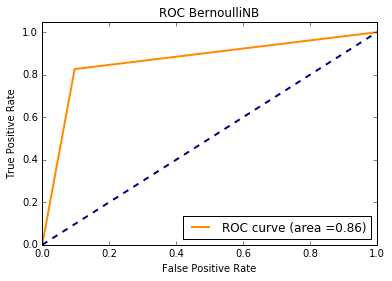

Confusion Matrix of BernoulliNB:

Confusion matrix, without normalization
[[261  28]
 [ 47 224]]


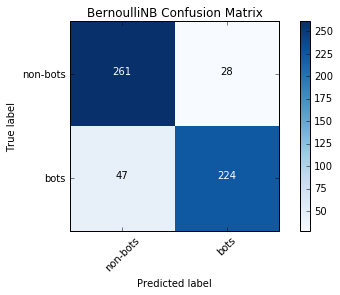

In [104]:
clfBN=classifier(BernoulliNB(),X_train_train,y_train_train,'BernoulliNB')

print len(prediction)

clfBN.CrossValueScore()
clfBN.predictScore(X_train_test,y_train_test)

prediction=clfBN.predict(X_train,y_train,X_test)
X_test_raw['bot']=prediction


#pd.value_counts(prediction)
submit=X_test_raw[['id','bot']]
submit.head()
submit.to_csv('BernoulliNB.csv')

Cross Value Score of Decision Tree:

Accuracy: [0.86, 0.83, 0.86, 0.87, 0.87] Average = 0.86
Precision:[0.90, 0.86, 0.90, 0.91, 0.91] Average = 0.9
Recall:   [0.78, 0.76, 0.78, 0.80, 0.82] Average = 0.79
f1:       [0.84, 0.81, 0.84, 0.85, 0.86] Average = 0.84
auc:      [0.91, 0.88, 0.90, 0.90, 0.92] Average = 0.9

Score on validation data Decision Tree:

Accuracy  = 0.87
Precision = 0.90
Recall    = 0.82
F1        = 0.86
Auc score = 0.87

ROC curve of Decision Tree:



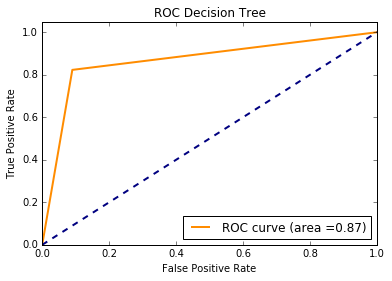

Confusion Matrix of Decision Tree:

Confusion matrix, without normalization
[[263  26]
 [ 48 223]]


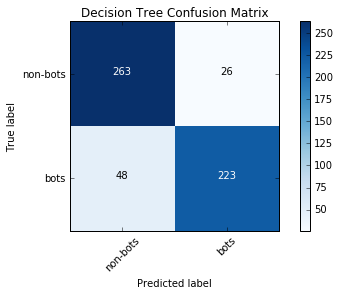

In [105]:
clfDT=classifier(tree.DecisionTreeClassifier(),X_train_train,y_train_train,'Decision Tree')
clfDT.CrossValueScore()
clfDT.predictScore(X_train_test,y_train_test)
prediction=clfDT.predict(X_train,y_train,X_test)
X_test_raw['bot']=prediction

#pd.value_counts(prediction)
submit=X_test_raw[['id','bot']]
submit.head()
submit.to_csv('Decision Tree.csv')


c:\python27\lib\site-packages\ipykernel\__main__.py:7: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Cross Value Score of Random Forest:

Accuracy: [0.86, 0.83, 0.86, 0.87, 0.87] Average = 0.86
Precision:[0.90, 0.86, 0.90, 0.91, 0.90] Average = 0.9
Recall:   [0.78, 0.76, 0.78, 0.80, 0.82] Average = 0.79
f1:       [0.84, 0.81, 0.84, 0.85, 0.86] Average = 0.84
auc:      [0.91, 0.88, 0.90, 0.90, 0.92] Average = 0.9

Score on validation data Random Forest:

Accuracy  = 0.87
Precision = 0.90
Recall    = 0.83
F1        = 0.86
Auc score = 0.87

ROC curve of Random Forest:



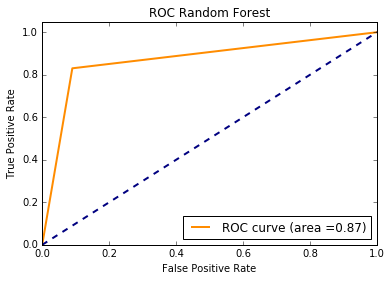

Confusion Matrix of Random Forest:

Confusion matrix, without normalization
[[263  26]
 [ 46 225]]


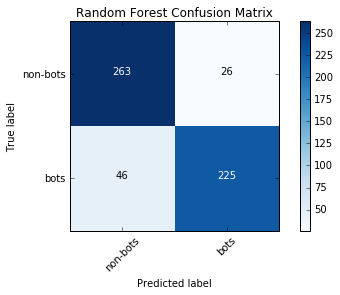

c:\python27\lib\site-packages\ipykernel\__main__.py:58: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


In [106]:
clfRF=classifier(RandomForestClassifier(),X_train_train,y_train_train,'Random Forest')
clfRF.CrossValueScore()
clfRF.predictScore(X_train_test,y_train_test)


prediction=clfRF.predict(X_train,y_train,X_test)
X_test_raw['bot']=prediction

pd.value_counts(prediction)
submit=X_test_raw[['id','bot']]
submit.to_csv('Random Forest.csv')

#p=X_test_raw[['id','bot']]
#p.to_csv('train.csv')


Cross Value Score of Gradient Boosting:

Accuracy: [0.85, 0.83, 0.86, 0.87, 0.87] Average = 0.86
Precision:[0.90, 0.86, 0.90, 0.91, 0.91] Average = 0.9
Recall:   [0.78, 0.75, 0.78, 0.80, 0.81] Average = 0.79
f1:       [0.83, 0.80, 0.84, 0.85, 0.86] Average = 0.84
auc:      [0.91, 0.88, 0.91, 0.90, 0.91] Average = 0.9

Score on validation data Gradient Boosting:

Accuracy  = 0.87
Precision = 0.89
Recall    = 0.82
F1        = 0.86
Auc score = 0.86

ROC curve of Gradient Boosting:



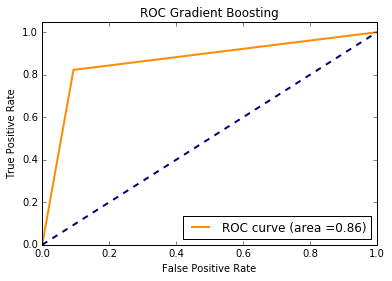

Confusion Matrix of Gradient Boosting:

Confusion matrix, without normalization
[[262  27]
 [ 48 223]]


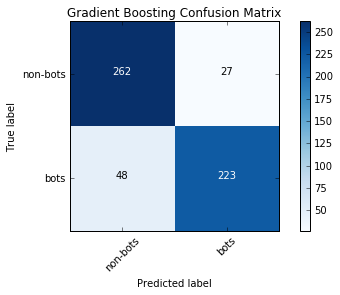

In [107]:
clfGB=classifier(GradientBoostingClassifier(),X_train_train,y_train_train,'Gradient Boosting')
clfGB.CrossValueScore()
clfGB.predictScore(X_train_test,y_train_test)

prediction=clfGB.predict(X_train,y_train,X_test)
X_test_raw['bot']=prediction

pd.value_counts(prediction)
submit=X_test_raw[['id','bot']]
submit.to_csv('Gradient Boosting.csv')

Cross Value Score of SVM:

Accuracy: [0.85, 0.83, 0.86, 0.87, 0.87] Average = 0.85
Precision:[0.88, 0.86, 0.90, 0.92, 0.91] Average = 0.89
Recall:   [0.79, 0.75, 0.78, 0.79, 0.81] Average = 0.79
f1:       [0.83, 0.80, 0.84, 0.85, 0.86] Average = 0.84
auc:      [0.88, 0.86, 0.89, 0.89, 0.90] Average = 0.88

Score on validation data SVM:

Accuracy  = 0.87
Precision = 0.90
Recall    = 0.82
F1        = 0.86
Auc score = 0.87

ROC curve of SVM:



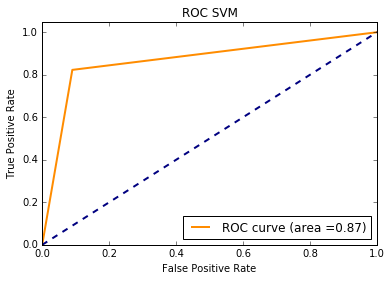

Confusion Matrix of SVM:

Confusion matrix, without normalization
[[263  26]
 [ 48 223]]


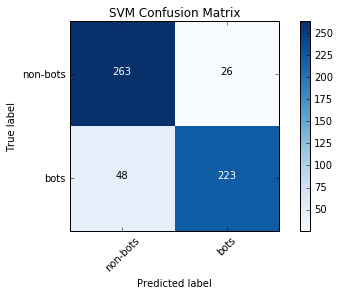

In [108]:
clfSVM=classifier(SVC(),X_train_train,y_train_train,'SVM')
clfSVM.CrossValueScore()
clfSVM.predictScore(X_train_test,y_train_test)

Cross Value Score of Neural Network:

Accuracy: [0.84, 0.81, 0.84, 0.86, 0.85] Average = 0.84
Precision:[0.86, 0.83, 0.87, 0.89, 0.85] Average = 0.86
Recall:   [0.79, 0.75, 0.78, 0.80, 0.81] Average = 0.79
f1:       [0.82, 0.79, 0.82, 0.84, 0.83] Average = 0.82
auc:      [0.90, 0.87, 0.90, 0.90, 0.90] Average = 0.89

Score on validation data Neural Network:

Accuracy  = 0.86
Precision = 0.87
Recall    = 0.83
F1        = 0.85
Auc score = 0.86

ROC curve of Neural Network:



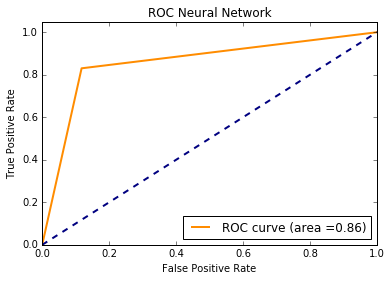

Confusion Matrix of Neural Network:

Confusion matrix, without normalization
[[255  34]
 [ 46 225]]


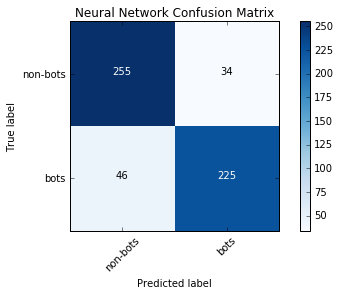

In [109]:
clfNN=classifier(MLPClassifier(solver='lbfgs', alpha=1e-5,hidden_layer_sizes=(11, ), random_state=1),X_train_train,y_train_train,'Neural Network')
clfNN.CrossValueScore()
clfNN.predictScore(X_train_test,y_train_test)

prediction=clfNN.predict(X_train,y_train,X_test)
X_test_raw['bot']=prediction

pd.value_counts(prediction)
submit=X_test_raw[['id','bot']]
submit.to_csv('Neural Network.csv')

Cross Value Score of Logistic Regression L2, C=1:

Accuracy: [0.84, 0.81, 0.84, 0.86, 0.85] Average = 0.84
Precision:[0.86, 0.83, 0.87, 0.89, 0.85] Average = 0.86
Recall:   [0.79, 0.75, 0.78, 0.80, 0.81] Average = 0.79
f1:       [0.82, 0.79, 0.82, 0.84, 0.83] Average = 0.82
auc:      [0.90, 0.87, 0.90, 0.90, 0.90] Average = 0.89

Score on validation data Logistic Regression L2, C=1:

Accuracy  = 0.86
Precision = 0.87
Recall    = 0.83
F1        = 0.85
Auc score = 0.86

ROC curve of Logistic Regression L2, C=1:



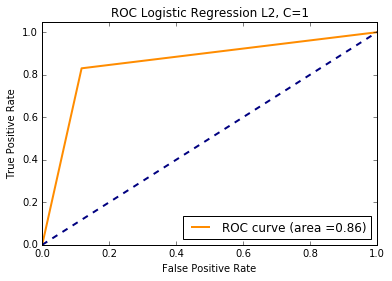

Confusion Matrix of Logistic Regression L2, C=1:

Confusion matrix, without normalization
[[255  34]
 [ 46 225]]


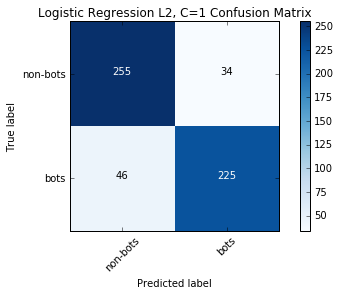

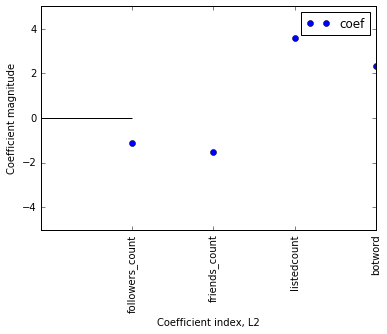

In [110]:
clfLRL2C1=classifier(LogisticRegression(),X_train_train,y_train_train,'Logistic Regression L2, C=1')
clfLRL2C1.CrossValueScore()
clfLRL2C1.predictScore(X_train_test,y_train_test)

prediction=clfLRL2C1.predict(X_train,y_train,X_test)
X_test_raw['bot']=prediction

pd.value_counts(prediction)
submit=X_test_raw[['id','bot']]
submit.to_csv('Logistic Regressioon.csv')

plt.plot(clfLRL2C1.clf.coef_.T,'o',label="coef")
plt.xticks(range(X_train.shape[1]),X_train.columns.tolist(),rotation=90)
plt.hlines(0,0,clfLRL2C1.clf.coef_)
plt.ylim(-5,5)
plt.xlabel("Coefficient index, L2")
plt.ylabel("Coefficient magnitude")
plt.legend()
plt.show()

#print clfLRL2C1.clf.coef_

In [111]:
#clfLRL2C100=classifier(LogisticRegression(penalty='l2',C=100),X_train,y_train,'Logistic Regression L2, C=100')
#clfLRL2C100.CrossValueScore()
#clfLRL2C100.predictScore(X_test,y_test)

In [112]:
#clfLRL2C0001=classifier(LogisticRegression(penalty='l2',C=0.001),X_train,y_train,'Logistic Regression L2, C=0.001')
#clfLRL2C0001.CrossValueScore()
#clfLRL2C0001.predictScore(X_test,y_test)

In [113]:
#clfLRL1C1=classifier(LogisticRegression(penalty='l1'),X_train,y_train,'Logistic Regression L1, C=1')
#clfLRL1C1.CrossValueScore()
#clfLRL1C1.predictScore(X_test,y_test)


In [114]:
#clfLRL1C100=classifier(LogisticRegression(penalty='l1',C=100),X_train,y_train,'Logistic Regression L1, C=100')
#clfLRL1C100.CrossValueScore()
#clfLRL1C100.predictScore(X_test,y_test)


In [115]:
#clfLRL1C0001=classifier(LogisticRegression(penalty='l1',C=0.001),X_train,y_train,'Logistic Regression L1, C=0.001')
#clfLRL1C0001.CrossValueScore()
#clfLRL1C0001.predictScore(X_test,y_test)
#X_train.shape